# Image Classification with PyTorch: Trying different image data augmentations when training a CNN

[Pablo Carballeira] (http://dymas.ii.uam.es/webvpu/gti/user/186/), Escuela Politecnica Superior, Universidad Autónoma de Madrid.

Parts of this code have been adapted from then work of Kevin McGuinness (http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University, and the work of Ben Trevett (https://github.com/bentrevett), Heriot-Watt University

You can find documentation about working in Colab here (https://colab.research.google.com/notebooks/intro.ipynb)

---

In this lab assignment you will try different image data augmentation techniques to train a ResNet CNN on the CIFAR10 datastet. The objective of this assignment is that you try different data augmentation options and evaluate which is more efficient for your problem.

# Instructions

Go to the Section "Load data and define the image transformations" and modify it to try different image data augmentation techniques. You can also play with different values of the parameters of the transformations you utilize.

Each time you set a new set of transformations (training and validation), you have to run the whole notebook to evaluate its influence in the training process


# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [2]:
# make sure to enable GPU acceleration!
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


We set the random seed so all of our experiments can be reproduced.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset: CIFAR10

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)



## Mean and standard deviation of the dataset

Here, we calculate the mean and standard deviation of our data so we can normalize it appropiately. CIFAR10 is made up of color images with three color channels (red, green and blue). To normalize the data we need to calculate the means and standard deviations for each of the color channels independently. 



In [4]:
ROOT = '.data/CIFAR10'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

# use the functions that are built in the dataset to compute the means and stds. 
# Bear in mind that image pixels are in the [0,255] range, but they are converted to
# het [0,1] range when transformed to Tensor variables 
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


# CNN architecture: Residual Network

We will use a 11-layer ResNet model adapted to the resolution of the images of the CIFAR10 dataset. Here we define the network architecture and instantiate the model with random weights. 


In [5]:
class _Block(nn.Module):
    def __init__(self, kernel_dim, n_filters, in_channels, stride, padding):
        super(_Block, self).__init__()
        self._layer_one = nn.Conv2d(in_channels=in_channels, out_channels=n_filters, 
                                  kernel_size=kernel_dim, stride=stride[0], padding=padding, bias=False)
        self._layer_two = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, 
                                  kernel_size=kernel_dim, stride=stride[1], padding=padding, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.bn2 = nn.BatchNorm2d(n_filters)
    def forward(self, X, shortcut = None):
        output = self._layer_one(X)
        output = self.bn1(output)
        output = self.relu(output)
        output = self._layer_two(output)
        output = self.bn2(output)
        output = self.relu(output)
        if isinstance(shortcut, torch.Tensor):
            return output + shortcut
        return output + X
class ResNet(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(ResNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(3, 64, 4, 2)
        self.block1 = _Block(5, 64, 64, (1,1), 2)
        self.block2 = _Block(5, 64, 64, (1,1), 2)
        self.block3 = _Block(5, 64, 64, (1,1), 2)
        self.transition1 = nn.Conv2d(64, 128, 1, 2, 0, bias=False)
        self.block4 = _Block(3, 128, 64, (2,1), 1)
        self.block5 = _Block(3, 128, 128, (1,1), 1)
        self.block6 = _Block(3, 128, 128, (1,1), 1)
        self.transition2 = nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.block7 = _Block(3, 256, 128, (2,1), 1)
        self.block8 = _Block(3, 256, 256, (1,1), 1)
        self.block9 = _Block(3, 256, 256, (1,1), 1)
        self.transition3 = nn.Conv2d(256, 512, 3, 2, 1, bias=False)
        self.block10 = _Block(3, 512, 256, (2,1), 1)
        self.block11 = _Block(3, 512, 512, (1,1), 1)
        self.block12 = _Block(3, 512, 512, (1,1), 1)
        self.linear1 = nn.Linear(2048, n_classes)
    
    def forward(self, X):
        output = self.conv1(X)
        output = self.block1(output)
        output = self.block2(output)
        output = self.block3(output)
        shortcut1 = self.transition1(output)
        output = self.block4(output, shortcut1)
        output = self.block5(output)
        output = self.block6(output)
        shortcut2 = self.transition2(output)
        output = self.block7(output, shortcut2)
        output = self.block8(output)
        output = self.block9(output)
        shortcut3 = self.transition3(output)
        output = self.block10(output, shortcut3)
        output = self.block11(output)
        output = self.block12(output)
        output = output.view(-1, 2048)
        output = self.linear1(output)
        return output


In [6]:
X = torch.ones((1,3,32,32))
model = ResNet(32, 10)
model.to(device)
X = X.to(device)
model(X)

tensor([[ 0.8172, -1.1241,  0.1782,  1.9127, -0.8584, -0.2324, -0.8083,  1.0576,
          0.1153, -0.8415]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Load data and define the image transforms 





In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])


In [8]:
train_set = datasets.CIFAR10(root = "./data", train=True, download = True, transform=train_transform)

valid_set = datasets.CIFAR10(root = "./data", train=False, download = True, transform=valid_transform)

BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=5, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f'train set is', ' x '.join(str(x) for x in train_set.data.shape))
print(f'valid set is', ' x '.join(str(x) for x in valid_set.data.shape))

train set is 50000 x 32 x 32 x 3
valid set is 10000 x 32 x 32 x 3


# Training the Model



## Set up training parameters


In [10]:
loss_fn = nn.CrossEntropyLoss()
LR = 0.001
optim = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=0.0001)
epoch_loss_DA = []
val_loss_DA = []
acc_DA = []
train_time = 0

EPOCHS = 15

## Train and evaluate

In [11]:
for i in range(EPOCHS):
    start_time = time.time()
    ep = 0
    model.train()
    for X_b, y_b in train_loader:
        optim.zero_grad()
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        output = model(X_b)
        loss = loss_fn(output, y_b)
        loss.backward()
        ep += loss.item()
        optim.step()
    epoch_loss_DA.append(ep*BATCH_SIZE/50000)
    train_time += time.time() - start_time
    
    correct = 0
    total = 0
    val = 0
    model.eval()
    
    for X_b, y_b in valid_loader:
        X_b = X_b.to(device)
        y_b = y_b.to(device)
        output = model(X_b)
        loss = loss_fn(output, y_b)
        val += loss.item()
        probs = torch.functional.F.softmax(output, 1)
        label = torch.argmax(probs, dim=1)
        correct += torch.sum(label == y_b).item()
        total += y_b.shape[0]
    val_loss_DA.append(val*BATCH_SIZE/10000)
    acc_DA.append(round(correct/total,2))
    
    print(f'[{i:03d}] train loss: {ep*BATCH_SIZE/50000:04f}  '
              f'val loss: {val*BATCH_SIZE/10000:04f}  '
              f'val acc: {correct/10000*100:.4f}%')
    
print("--- %s seconds ---", train_time)

        



[000] train loss: 125.787940  val loss: 98.787144  val acc: 31.7800%
[001] train loss: 102.152682  val loss: 89.552529  val acc: 35.2400%
[002] train loss: 94.348958  val loss: 82.254469  val acc: 41.2200%
[003] train loss: 90.489901  val loss: 75.273697  val acc: 45.8800%
[004] train loss: 88.064797  val loss: 74.198530  val acc: 47.1100%
[005] train loss: 86.350305  val loss: 71.273899  val acc: 50.0200%
[006] train loss: 84.544855  val loss: 69.686498  val acc: 49.7100%
[007] train loss: 83.526001  val loss: 69.529414  val acc: 51.0600%
[008] train loss: 82.227274  val loss: 68.086529  val acc: 52.6400%
[009] train loss: 81.345680  val loss: 63.924457  val acc: 55.6300%
[010] train loss: 80.331805  val loss: 70.970358  val acc: 51.5500%
[011] train loss: 79.619887  val loss: 63.797308  val acc: 56.1000%
[012] train loss: 78.831983  val loss: 67.216562  val acc: 53.5300%
[013] train loss: 78.647598  val loss: 67.541109  val acc: 53.9500%
[014] train loss: 77.863807  val loss: 64.7849

## Plot graphs


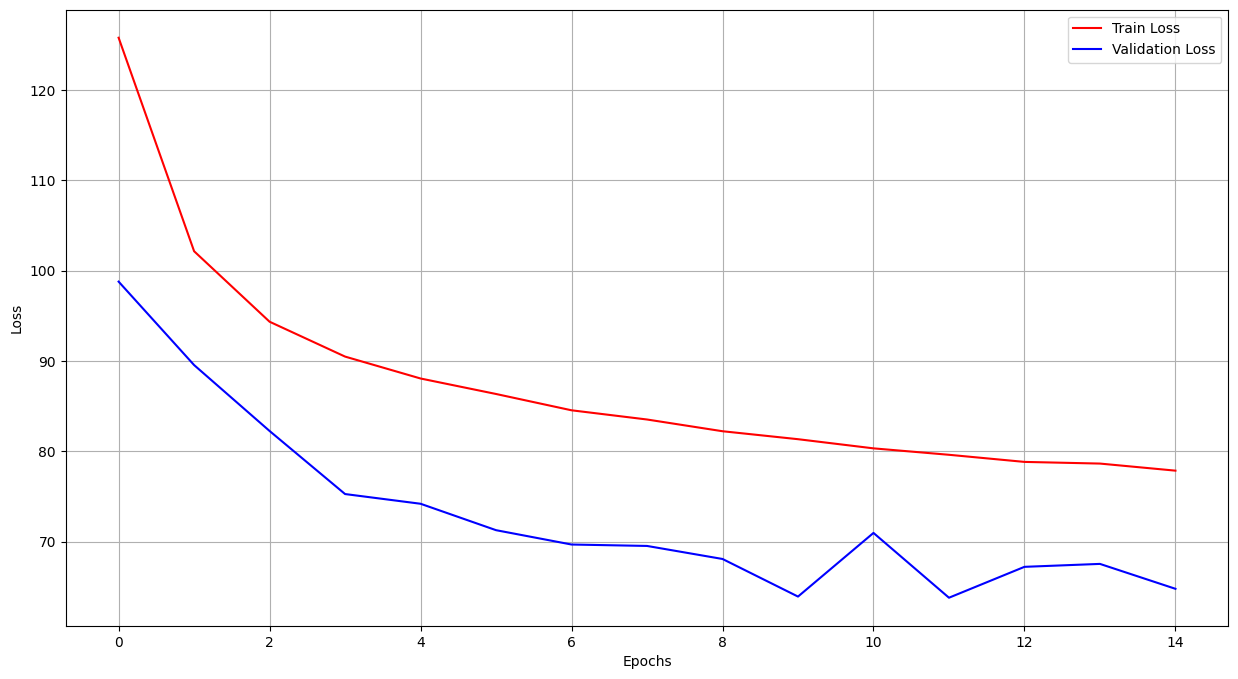

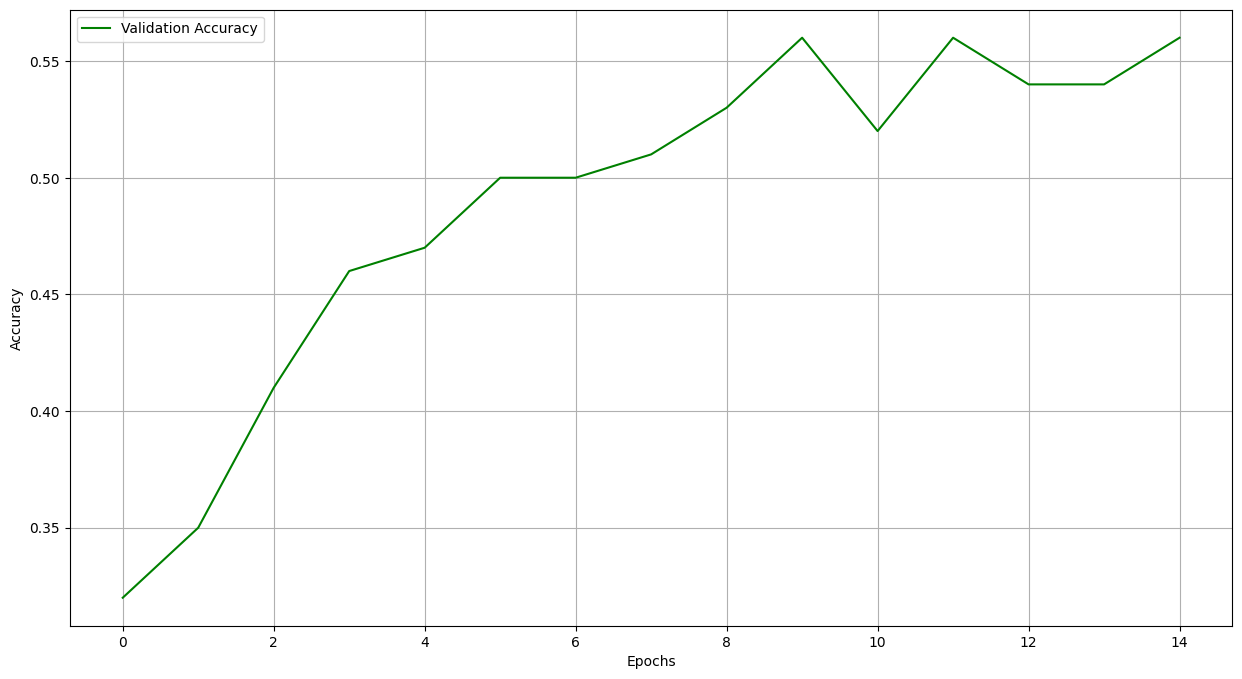

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(EPOCHS), epoch_loss_DA , color='r')
plt.plot(range(EPOCHS), val_loss_DA, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(EPOCHS), acc_DA , color='g')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)